In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense,LSTM,Conv2D, BatchNormalization,Flatten, MaxPooling2D
from keras.layers import Conv2DTranspose,Concatenate,UpSampling2D,Cropping2D
from keras.layers import Input, Lambda, Reshape, Dropout, Activation

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pathlib
import hashlib

dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *

In [2]:
# Define paths
config = dotenv_values(".env")
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']


In [3]:
# Some constants
DATE_START = '1979-01-01'
DATE_END = '2021-12-31'
# train -test (80/20 of total yy), train-> split 80/20 for validation
#YY_TRAIN = [1979, 2011] # 2005-2011 for validation
#YY_VAL = [2005,2011]
#YY_TEST = [2012, 2020]
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2021]
YY_VALID = 2005
LEVELS = [500, 850, 1000]
G = 9.80665 
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]

PRECIP_DATA = 'ERA5' # Options: ERA5, E-OBS
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes

# Data loading

### Load precipitation

In [4]:
# Load precipitation
if PRECIP_DATA == 'ERA5':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA in ['E-OBS', 'EOBS']:
    pr = get_nc_data(PATH_EOBS + '/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.rr
    pr = pr.coarsen(lon=5, lat=5, boundary="trim").mean()
    pr = pr.fillna(0) # Over the seas. Not optimal...
else:
    raise('Precipitation data not well defined')

Extracting data for the period 1979-01-01 - 2021-12-31


In [5]:
# Define extremes
pr95 = precip_exceedance_xarray(pr, PRECIP_XTRM)

### Load predictors

In [6]:
# define paths for the variables used
l_paths = ['/geopotential/grid1/','/temperature/grid1/','/relative_humidity/day_grid1/',
              '/U_wind/day_grid1/','/V_wind/day_grid1/','/total_column_water/day_grid1/']
v_vars = ['z','t2m','rh','u850','v850','tpcw']

In [7]:
list_vars = load_data(v_vars, l_paths, G, PATH_ERA5, DATE_START, DATE_END, LONS_INPUT, LATS_INPUT, LEVELS)

Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31


In [8]:
datasets = list_vars

In [9]:
# checking dimensions
print('dimension of pr:',pr.dims)
print('dimension of z',datasets[0].dims)
print('dimension of t2m:',datasets[1].dims)
print('dimension of rh:',datasets[2].dims)
print('dimension of u:',datasets[3].dims)
print('dimension of v:',datasets[4].dims)
print('dimension of tw:',datasets[5].dims)

dimension of pr: ('time', 'lat', 'lon')
dimension of z Frozen({'level': 3, 'time': 15706, 'lon': 56, 'lat': 46})
dimension of t2m: Frozen({'time': 15706, 'lon': 56, 'lat': 46})
dimension of rh: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 3})
dimension of u: Frozen({'time': 15706, 'lon': 56, 'lat': 46})
dimension of v: Frozen({'time': 15706, 'lon': 56, 'lat': 46})
dimension of tw: Frozen({'time': 15706, 'lon': 56, 'lat': 46})


In [10]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
#dic = OrderedDict({'z': 3, 'T2MMEAN':None, 'r':3})
dic = {
     'z': LEVELS,
      'T2MMEAN': None,
      'r': LEVELS,
      'u': None,
      'v': None,
      'tcwv':None}

In [11]:
# Check if all have the same latitude order
for idat in range(0, len(datasets)):
    # Invert lat axis if needed
    if datasets[idat].lat[0].values < datasets[idat].lat[1].values:
        print('change lat order', idat)
        datasets[idat] = datasets[idat].reindex(lat=list(reversed(datasets[idat].lat)))

change lat order 0
change lat order 1


In [12]:
ds = xr.merge(datasets)

In [13]:
BATCH_SIZE=64 # try increase, decrease it

In [14]:
# Split into training and test, then I will use DataGenerator class to get the validation
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))

dy_train = pr95.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
dy_test = pr95.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                             '{}-12-31'.format(YY_TEST[1])))

In [15]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = MyDataGenerator(ds_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                dy_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')), dic, batch_size= BATCH_SIZE, load=True)

Loading data into RAM


In [16]:
# Create a validation. Use the train mean and std for validation as well. And suffle
dg_val = MyDataGenerator(ds_train.sel(time=slice(f'{YY_VALID}', f'{YY_TRAIN[1]}')),
                                dy_train.sel(time=slice(f'{YY_VALID}', f'{YY_TRAIN[1]}')), dic, batch_size=BATCH_SIZE,  mean=dg_train.mean, std=dg_train.std, load=True)

Loading data into RAM


In [17]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = MyDataGenerator(ds_test, dy_test, dic, batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


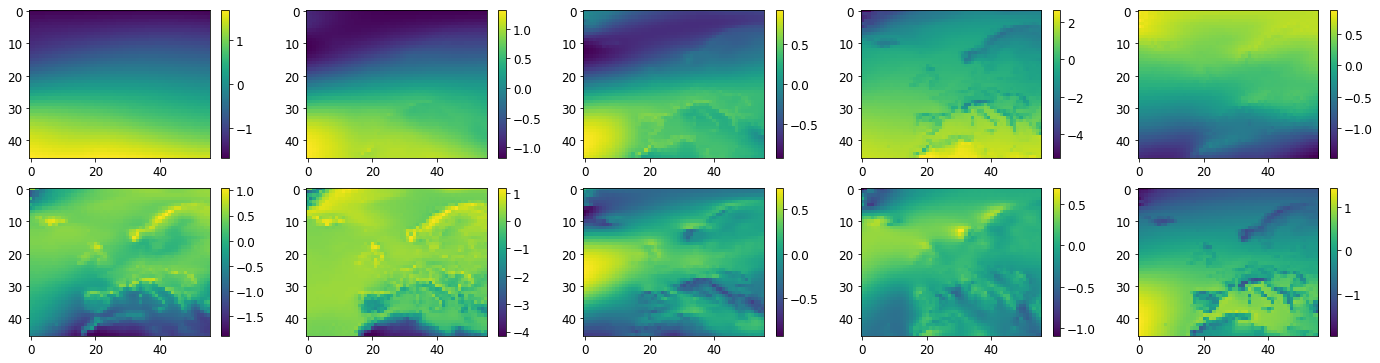

In [21]:
# checks
n_figs = len(dg_train.data[0,0,0,:])
ncols = 5
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    im = axes[i_row, i_col].imshow(np.mean(dg_train.data[:,:,:,i], axis=0))
    fig.colorbar(im, ax=axes[i_row, i_col])

In [22]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# U-Net architecture

In [23]:
# Define args for the U-net model
i_shape = dg_train.data.shape[1:]
o_shape = dg_train.labels.shape[1:]

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')
output_channels = 1
num_filters = 16
use_batchnorm = True
dropout = True
lr = 0.0004
optimizer = tf.optimizers.Adam(learning_rate = lr)
EPOCHS = 50
# Note: for U-net the input and output must be power of 2 ..
# I will re-define the input for an easier implementation

X shape: (46, 56, 10)
y shape: (46, 56)


In [24]:
METRICS = [
    tf.metrics.CategoricalAccuracy(name='accuracy'),
    tf.metrics.Precision(class_id = 1, name='precision'),
    tf.metrics.Recall(class_id = 1, name='recall')
]

2022-04-19 13:48:10.406879: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 13:48:11.252431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [25]:
weights = class_weight.compute_class_weight('balanced', classes = np.unique(dg_train.labels), y = np.array(dg_train.labels).flatten())

In [26]:
model_loss = weighted_binary_cross_entropy(weights = {0: weights[0].astype('float32'), 1: weights[1].astype('float32')})

### ResNet  

In [27]:
# I'll skip this for now, it's not working well..need to check if makes sense..

In [ ]:
m_res = Adapted_resnet(i_shape) 

In [ ]:
m_res.compile(optimizer = optimizer, loss = model_loss , metrics = METRICS)

In [ ]:
h_res = m_res.fit(dg_train, epochs=EPOCHS, validation_data= dg_val)

### More model architectures

#### 1. Pan et al. 2019 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024090)

In [28]:
pad = 'valid'
stride_factor=4
# Our shapes
output_size = [46,56,1]
# original inputs from the paper to reproduce fig.4
#i_shape = [25,25,4]
#output_size = [25,25,1]

In [29]:
inputs = layers.Input(shape=i_shape)
x = layers.Conv2D(15, 4, strides=(1,1), padding = pad)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(20, 4, strides=(1,1), padding = pad)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(20, 4, strides=(1,1), padding = pad)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(60)(x)
x = layers.Dense(1)(x)
x = layers.Activation('relu')(x)
#------------------------------------
# bottleneck for the upscalling part
next_shape = output_size.copy()
next_shape[0] = int(np.ceil(next_shape[0]/stride_factor))
next_shape[1] = int(np.ceil(next_shape[1]/stride_factor))

x = layers.Dense(np.prod(next_shape), activation='relu')(x)
x = layers.Reshape(target_shape=next_shape)(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='softmax')(x)
outputs = crop_output(inputs,x)

model = keras.Model(inputs, outputs, name="Pan-2019")

In [30]:
model.summary()

Model: "Pan-2019"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46, 56, 10)]      0         
                                                                 
 conv2d (Conv2D)             (None, 43, 53, 15)        2415      
                                                                 
 batch_normalization (BatchN  (None, 43, 53, 15)       60        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 43, 53, 15)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 50, 20)        4820      
                                                                 
 batch_normalization_1 (Batc  (None, 40, 50, 20)       80        
 hNormalization)                                          

In [31]:
# Model train
model.compile(optimizer =optimizer, loss = model_loss , metrics = METRICS)

In [32]:
his_pmodel = model.fit(dg_train, epochs=EPOCHS, validation_data= dg_val)

Epoch 1/50


2022-04-19 13:48:32.592461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


155/155 [==============================] - 8s 26ms/step - loss: 7.6246 - accuracy: 0.5311 - precision: 0.0486 - recall: 1.0000 - val_loss: 7.6084 - val_accuracy: 0.5204 - val_precision: 0.0523 - val_recall: 1.0000
Epoch 2/50
155/155 [==============================] - 3s 22ms/step - loss: 7.6246 - accuracy: 0.5311 - precision: 0.0486 - recall: 1.0000 - val_loss: 7.6084 - val_accuracy: 0.5204 - val_precision: 0.0523 - val_recall: 1.0000
Epoch 3/50
155/155 [==============================] - 3s 22ms/step - loss: 7.6246 - accuracy: 0.5311 - precision: 0.0486 - recall: 1.0000 - val_loss: 7.6084 - val_accuracy: 0.5204 - val_precision: 0.0523 - val_recall: 1.0000
Epoch 4/50
155/155 [==============================] - 3s 22ms/step - loss: 7.6246 - accuracy: 0.5311 - precision: 0.0486 - recall: 1.0000 - val_loss: 7.6084 - val_accuracy: 0.5204 - val_precision: 0.0523 - val_recall: 1.0000
Epoch 5/50
155/155 [==============================] - 3s 21ms/step - loss: 7.6246 - accuracy: 0.5311 - precisio

In [34]:
model.save('tmp/model_test')

2022-04-19 13:53:17.383698: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tmp/model_test/assets


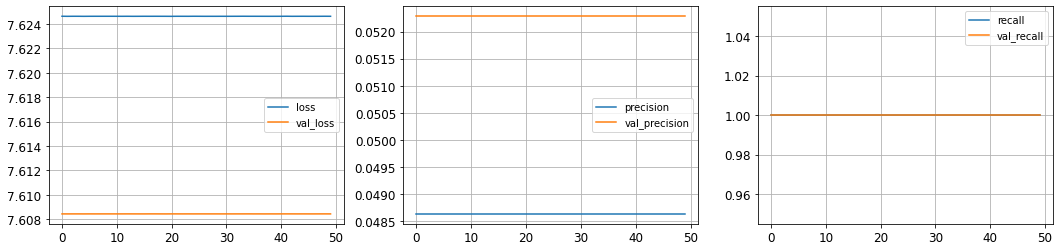

In [33]:
figure, axis = plt.subplots(1, 3)

# For Sine Function
pd.DataFrame(his_pmodel.history)[['loss','val_loss']].plot(figsize=(18,4), ax=axis[0], grid=True)
pd.DataFrame(his_pmodel.history)[['precision','val_precision']].plot(figsize=(18,4), ax=axis[1],grid=True)
pd.DataFrame(his_pmodel.history)[['recall','val_recall']].plot(figsize=(18,4), ax=axis[2],grid=True)
plt.show()

#### 2. Shi2020 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL090309)

In [ ]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, SeparableConvolution2D

#### 2.1. RaNet

In [ ]:
# In this case using conv3D the input has to be 4D tensor, so it is splitted in lev, lat,lon, var
i_shape = [7, 46, 56,3]
#i_shape = [6, 12, 12, 5] #--> shape used in Shi2020

In [ ]:
inputs = layers.Input(shape=i_shape)
x = layers.Conv3D(128, kernel_size=(3, 3, 3),padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling3D()(x)
x = layers.Conv3D(256, kernel_size=(3, 3, 3),padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling3D()(x)
x = layers.Conv3D(512, kernel_size=(3, 3, 3),padding="same")(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
#---------note: we can skip the 3-last fully connected layers to add the upscalling part (?)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='softmax')(x)
outputs = layers.Dropout(0.2)(x)
model = keras.Model(inputs, outputs, name="RaNet")

In [ ]:
model.summary()  

#### 2.2. RxNet

In [ ]:
from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras import backend as K

In [ ]:
def Xception(i_shape, upscalling = True, include_top=False, pooling=None, classes=1):
    """ Adapted from : https://github.com/fchollet/deep-learning-models/blob/master/xception.py
        and Shi2020 
    # Arguments
        i_shape: shape tuple to be specified
        upscalling: if we want to do upscalling instead Avg pooling
        include_top: whether to include the fully-connected
            layer at the top of the network.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
      """

 
    img_input = Input(shape=i_shape)
    
    x = Conv2D(128, (3,3), strides = (2,2), padding='same',use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(256, (3,3), padding='same' )(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)
    
    residual = Conv2D(512, (1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    x = SeparableConv2D(512, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(512, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)
    x = MaxPooling2D((1,1), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1),  padding='same')(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x) 
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)
    
    x = MaxPooling2D((1, 1),  padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    for i in range(1):
   # for i in range(6):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    # last part
    
    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)
    
    x = MaxPooling2D((2, 2),  padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])
    

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)
    
    if upscalling:
        x = Conv2DTranspose(1536, (3, 3), strides = (2,2), padding='same', activation='relu')(x)
        x = Conv2DTranspose(1024, (3, 3), strides = (2,2), padding='same', activation='relu')(x)
        x = Dense(1, activation='softmax', name='predictions')(x)
        # final crop
        x = crop_output(img_input, x)
        
    else:
        if include_top:
            x = GlobalAveragePooling2D(name='avg_pool')(x)
            x = Dense(classes, activation='softmax', name='predictions')(x)
        else:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)
        

   

    # Create model.
    model = Model(img_input, x, name='xception')
    return model
    

In [ ]:
i_shape  = [46, 56,10]

In [ ]:
mx = Xception(i_shape, include_top=True, pooling=None, classes=1)

In [ ]:
mx.summary()

In [ ]:
mx.compile(optimizer =optimizer, loss = model_loss , metrics = METRICS)
his_mx = mx.fit(dg_train, epochs=EPOCHS, validation_data= dg_val)

In [ ]:
figure, axis = plt.subplots(1, 3)

# For Sine Function
pd.DataFrame(his_mx.history)[['loss','val_loss']].plot(figsize=(18,4), ax=axis[0], grid=True)
pd.DataFrame(his_mx.history)[['precision','val_precision']].plot(figsize=(18,4), ax=axis[1],grid=True)
pd.DataFrame(his_mx.history)[['recall','val_recall']].plot(figsize=(18,4), ax=axis[2],grid=True)
plt.show()

### Attention augmented CNN- Huang 2022 https://arxiv.org/abs/2201.13408

In [ ]:
import tensorflow as tf
tf.version.VERSION

In [ ]:
from utils.layer_augmented_conv2D import *

In [ ]:
ip = Input(shape=i_shape)

In [ ]:
#ip = Input(shape=(15,35,2)) # original shape

In [ ]:
# note: I could not make it work , it seems it has memory issues

In [ ]:
x = augmented_conv2d(ip, 16, kernel_size=(3, 3), strides=(1, 1),
                          k=float(0.2), v=float(0.2),
                          num_heads=1, relative_encodings=True)
x = MaxPooling2D((1,1))(x)
x = Dropout(0.2)(x)
x = augmented_conv2d(x, 16, kernel_size=(3, 3), strides=(1, 1),
                          k=float(0.2), v=float(0.2),
                          num_heads=1, relative_encodings=True)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)
#  here, it will go highway layer
# ----------------------also I skip this part and go add the upscalling layer
#x = Flatten()(x)
#x = layers.Dense(60)(x)
#x = layers.Dense(1)(x)
# upscalling part
x = Conv2DTranspose(1, (3, 3), strides = (2,2), padding='same', activation='softmax')(x)
m_aug = Model(ip, x)

In [ ]:
m_aug.summary()

In [ ]:
m_aug.compile(optimizer =optimizer, loss = model_loss , metrics = METRICS)
his_m_aug = m_aug.fit(dg_train, epochs=2, validation_data= dg_val)